## Step 0: Preparation

Before we begin with any actual code, let's make sure that we have everything we need.

In [1]:
!pip install -U flwr["simulation"]

zsh:1: no matches found: flwr[simulation]


In [1]:
from collections import OrderedDict
from typing import List, Tuple

# import flwr as fl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
# from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import os

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Try "cuda" to train on GPU
# print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")


### Loading the data


In [2]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
NUM_CLIENTS = 10

In [4]:
!pwd

/Users/ehsanulkabir/DBA_mod


In [4]:
BATCH_SIZE = 32

def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
    )
    trainset = CIFAR10("./data", train=True, download=True, transform=transform)
    testset = CIFAR10("./data", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


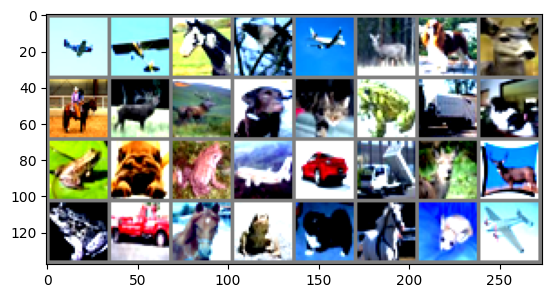

plane plane horse  bird plane  deer   dog  deer horse  deer  deer   dog   cat  frog truck   dog  frog   dog  frog plane   car truck  deer  deer  frog truck horse  frog   dog horse   dog plane


In [6]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

images, labels = next(iter(trainloaders[0]))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % CLASSES[labels[j]] for j in range(32)))

## Step 1: Federated Learning 


In [2]:
import pytorch_lightning as pl

from gradattack.models import LightningWrapper


class TrainingPipeline:
    def __init__(
            self,
            model: LightningWrapper,
            train_loader, val_loader, test_loader,
            trainer: pl.Trainer,
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.trainer = trainer
        self.applied_defenses = []
        self._data_transformations = []  # Modifications to the dataloader
        self._model_transformations = (
            []
        )  # Modifications to the model architecture, trainable params ...

    def log_hparams(self):
        self.trainer.logger.log_hyperparams(self.model.hparams)

    def setup_pipeline(self):

        for transform in self._model_transformations:
            transform(self.model)

    def run(self):
        self.setup_pipeline()
        # If we didn't call setup(), any updates to transforms (e.g. from defenses) wouldn't be applied
        return self.trainer.fit(self.model, train_dataloader=self.train_loader, val_dataloaders=self.val_loader)

    def test(self):
        return self.trainer.test(
            self.model, test_dataloaders=self.test_loader)



In [3]:
# from gradattack.models import resnet
from models import resnet_cifar as resnet

def create_lightning_module(
    model_name: str,
    num_classes: int,
    pretrained: bool = False,
    ckpt: str = None,
    freeze_extractor: bool = False,
    *args,
    **kwargs,
) -> LightningWrapper:

    _model = resnet.ResNet18()

    if ckpt is not None:
        assert os.path.exists(ckpt), f"Failed to load checkpoint {ckpt}"
        checkpoint = torch.load(ckpt, map_location=torch.device("cpu"))
        pretrained_dict = checkpoint["state_dict"]
        pretrained_dict = {
            k.replace("_model.", ""): v
            for k, v in pretrained_dict.items()
            # if "fc" not in k and "classifier" not in k
        }
        pretrained_dict = {
            k.replace("module.", ""): v
            for k, v in pretrained_dict.items()
            # if "fc" not in k and "classifier" not in k
        }  # Unwrap data parallel model
        _model.load_state_dict(pretrained_dict, strict=False)

    # if freeze_extractor:
    #     do_freeze_extractor(_model)
    #     _model.classifier = nn.Sequential(StandardizeLayer(n_features=1024),
    #                                       nn.Linear(1024, num_classes))
    return LightningWrapper(_model, *args, **kwargs)


In [4]:
from collections import OrderedDict

import flwr as fl
import pytorch_lightning as pl
import torch
from gradattack.datamodules import CIFAR10DataModule
from gradattack.utils import parse_args, parse_augmentation
from pytorch_lightning.loggers import TensorBoardLogger


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, train_loader, val_loader, test_loader, trainer, cid):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.cid = cid
        self.pipeline = TrainingPipeline(model, train_loader, val_loader, test_loader, trainer)

    def get_parameters(self, config):
        p = _get_parameters(self.model)
        return p

    def set_parameters(self, parameters):
        _set_parameters(self.model, parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)

        self.pipeline.run()

        return self.get_parameters(config={}), len(self.train_loader), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)

        results = self.pipeline.test()
        # loss = results[0]["test_loss"]
        loss = results[0]["run/test_loss"]
        accuracy = results[0]["run/test_accuracy"]
        
        return float(loss), len(self.val_loader), {"loss": float(loss), "accuracy": float(accuracy)}


def _get_parameters(model):
    return [val.cpu().numpy() for _, val in model.state_dict().items()]


def _set_parameters(model, parameters):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)


def build_model(client_number, ckpt=None):
    args = {
        "logname": "vanilla",
        "optimizer": "SGD",
        "scheduler": "ReduceLROnPlateau",
        "gpuid": 0,
        "batch_size": 32,
        "tune_on_val": 0.02,
        "ckpt": ckpt,
        "freeze_extractor": False,
        "log_auc": False,
        "n_epoch": 1,
        "aug_hflip": True,
        "aug_crop": True,
        "aug_rotation": 0,
        "aug_colorjitter": None,
        "aug_affine": False,
        "n_accumulation_steps": 1
    }

    hparams = {
    "optimizer": "SGD",
    "lr": 0.05,
    "weight_decay": 5e-4,
    "momentum": 0.9,
    "nesterov": False,
    "lr_scheduler": "ReduceLROnPlateau",
    "tune_on_val": 0.02,
    "batch_size": 32,
    }
    logger = TensorBoardLogger(
        "tb_logs", name=f'{args["logname"]}_{client_number}/{args["optimizer"]}/{args["scheduler"]}')
    devices = [args["gpuid"]]

    augment = {
        "hflip": args["aug_hflip"],
        "crop": args["aug_crop"],
        "rotation":
        args["aug_rotation"],
        "color_jitter": [float(i) for i in args["aug_colorjitter"]]
        if args["aug_colorjitter"] is not None else None,
        "affine":args["aug_affine"],
    }

    # datamodule = CIFAR10DataModule(
    #     augment=augment,
    #     batch_size=args["batch_size"],
    #     tune_on_val=args["tune_on_val"],
    #     batch_sampler=None,
    # )
    multi_head = False
    loss = torch.nn.CrossEntropyLoss(reduction="mean")

    model = create_lightning_module(
        "ResNet18",
        10,
        pretrained=False,
        ckpt=args["ckpt"],
        freeze_extractor=args["freeze_extractor"],
        training_loss_metric=loss,
        log_auc=args["log_auc"],
        multi_class=False,
        multi_head=multi_head,
        **hparams,
    )

    trainer = pl.Trainer(
        # gpus=1,
        check_val_every_n_epoch=1,
        deterministic=False,
        logger=logger,
        max_epochs=args["n_epoch"],
        accumulate_grad_batches=args["n_accumulation_steps"],
    )
    return model, trainer


In [21]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    print(torch.cuda.device_count())
    torch.cuda.is_available() 
    # Load model
    model, trainer = build_model(cid, ckpt='utils/model_bank/cifar/model_last.pt.tar.epoch_200')

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    print(f"create new client {cid}")
    return FlowerClient(model, trainloader, valloader, testloader, trainer, cid)

### Starting the training


In [22]:
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results,
        failures,):
        # save local updates
        # weights_results = [parameters_to_ndarrays(fit_res.parameters)
        #     for _, fit_res in results
        # ]
        # print("local updates=================")
        # print(weights_results)
        # print(results)
        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Save aggregated_ndarrays
            print(f"Saving round {server_round} aggregated_ndarrays...")
            np.savez(f"round-{server_round}-weights.npz", *aggregated_ndarrays)

        return aggregated_parameters, aggregated_metrics

# Create strategy and run server
strategy = SaveModelStrategy(
    # (same arguments as FedAvg here)
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

In [23]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
        min_fit_clients=10,  # Never sample less than 10 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=10,  # Wait until all 10 clients are available
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
    client_resources={"num_cpus": 2, "num_gpus": 1}
)

ImportError: Unable to import module `ray`.

To install the necessary dependencies, install `flwr` with the `simulation` extra:

    pip install -U flwr["simulation"]




# Ensemble gradient

In [8]:
import numpy as np
import torch
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, cosine_similarity

from gradattack.datamodules import CIFAR10DataModule
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def flatten_gradient_v2(state_dict):
    layer_names = list(state_dict.keys())
    # only keep bias and weight
    for name in layer_names:
        if 'bias' in name or 'weight' in name:
            continue
        else:
            layer_names.remove(name)
    grad = []
    for idx, name in enumerate(layer_names):
        grad.append(state_dict[name].cpu().data.numpy().flatten())

    grad = np.hstack(grad)
    return grad


def weighted_average_oracle(cluster_state_dicts, weights):
    tot_weights = torch.sum(weights)
    weighted_updates = dict()

    # try:
    #     for name, data in points[0].items():
    #         weighted_updates[name] = torch.zeros_like(data)
    # except:
    #     print(f'[rfa agg] points[0]: {points[0]}')
    for key, value in cluster_state_dicts[0].items():
        weighted_updates[key] = torch.zeros_like(value)
    for weight, state_dict in zip(weights, cluster_state_dicts):
        for layer, param in weighted_updates.items():
            temp = (weight / tot_weights).float()
            temp = temp * (state_dict[layer].float())
            if temp.dtype != param.dtype:
                temp = temp.type_as(param)
            param.add_(temp)

    return weighted_updates


def cluster_fun(coses, k, clustering_method='Agglomerative'):
    if clustering_method == 'Agglomerative':
        clustering = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='complete').fit(coses)
    elif clustering_method == 'KMeans':
        clustering = KMeans(n_clusters=k).fit(coses)
    elif clustering_method == 'Spectral':
        clustering = SpectralClustering(n_clusters=k, affinity='precomputed').fit(coses)
    return clustering


def get_optimal_k_for_clustering(grads, clustering_method='Agglomerative'):
    coses = []
    nets = grads
    coses = cosine_distances(nets, nets)
    coses = np.array(coses)
    np.fill_diagonal(coses, 0)

    sil = []
    minval = 2

    for k in range(minval, min(len(nets), 15)):
        # cluster grads according to cosine distances
        clustering = cluster_fun(coses, k, clustering_method)
        #    >>> clustering.labels => array([1, 1, 1, 0, 0, 0])
        labels = clustering.labels_
        # get goodness of clustering. return the index of the best clustered gradient.
        sil.append(silhouette_score(coses, labels, metric='precomputed'))
    # return the best clustering size
    return sil.index(max(sil)) + minval, coses

def cluster_grads(grads, clustering_method='Spectral'):
    # cluster gradients from all the users
    nets = grads
    X = nets

    # k: optimal k clustering, cluster grads into k sets.
    k, coses = get_optimal_k_for_clustering(grads, clustering_method)

    clustering = cluster_fun(coses, k, clustering_method)

    clusters = [[] for _ in range(k)]
    for i, label in enumerate(clustering.labels_.tolist()):
        clusters[label].append(i)
    for cluster in clusters:
        cluster.sort()
    clusters.sort(key=lambda cluster: len(cluster), reverse=True)
    print(clusters)
    return clustering.labels_, clusters

def generate_ensemble(client_state_dicts, bijective_florida=False):
    # bijective florida decides which florida to use: if True, then the bijective florida is used else cluster-based florida is used

    # flattens the model update to a 1D vector
    # you might need to update flatten_gradient_v2 depending on your model
    # delta_models contains the model updates from all the agents
    grads = [flatten_gradient_v2(state_dict) for state_dict in client_state_dicts]
    norms = [np.linalg.norm(grad) for grad in grads]

    if bijective_florida:
        clusters_agg = [[i] for i in range(len(grads))]
    else:
        clustering_method = 'Agglomerative'
        # cluster_grads returns the clusters: a list of lists, where each list contains the indices of the agents in that cluster
        # clusters_agg: clustered grades, sorted by size of each cluster
        _, clusters_agg = cluster_grads(grads, clustering_method)
    
    num_clusters = len(clusters_agg)
    # iterate through all the clusters
    for idx, cluster in enumerate(clusters_agg):
        print(idx, cluster)
        # new_model is a function that creates a new model from scratch
        # target_model is previous iteration's global model
        agg_model, agg_trainer = build_model(idx)
        # target_model, target_trainer =  build_model(idx+ 100)
        # load round-2-weights
        # global_state_dict = load_npz_to_state_dict('./drive/MyDrive/dl/checkpoints/round-2-weights.npz')
        agg_model.load_state_dict(global_state_dict)
        weight_vec = np.zeros(len(grads), dtype=np.float32)

        # for all local updates from the same cluster assign weight to it. ==> use the mean of the params from the same cluster
        if not bijective_florida:
            for i in range(len(grads)):
                if i in cluster:
                    weight_vec[i] = 1 / len(cluster)
            print("weight==================")
            print(weight_vec)
        else:
            cos_sims = np.array(cosine_similarity(grads, [grads[clusters_agg[idx][0]]])).flatten()
            trust_scores = np.zeros(cos_sims.shape)
            for i in range(len(cos_sims)):
                trust_scores[i] = cos_sims[i]
                trust_scores[i] = max(trust_scores[i], 0)

            norm_ref = norms[clusters_agg[idx][0]]
            clip_vals = [min(norm_ref / norm, 1) for norm in norms]
            trust_scores = [ts * cv for ts, cv in zip(trust_scores, clip_vals)]
            weight_vec = trust_scores

  
        # weighted_average_oracle is a function that takes in the model updates and the weights and returns the aggregated model update
        # you may need to update weighted_average_oracle depending on your model
        # aggregate_weights is the ensemble model update
        aggregate_weights = weighted_average_oracle([client_state_dicts[i] for i in cluster], torch.tensor(weight_vec))

        # # adds the ensemble model update to the global model and finds the ensemble model
        for key, value in agg_model.state_dict().items():
            update_per_layer = aggregate_weights[key]
            try:
                value.add_(update_per_layer)
            except:
                value.add_(update_per_layer.to(value.dtype))
    torch.save({'state_dict':agg_model.state_dict()}, "ensemble_model.ckpt")
    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
client_gradient_pt = torch.load('/content/drive/MyDrive/dl/gradA_data/client_gradient_list.pt')

In [15]:
# get keys of state_dict
ttt, asdsdad = build_model(1000)
print(type(ttt.state_dict()))
model_keys = ttt.state_dict().keys()

def load_npz_to_state_dict(file_name):
    global_npz = np.load(file_name)
    s = [global_npz[key] for key in global_npz]
    params_dict = zip(model_keys, s)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    return state_dict

def load_ckpt(file_name):
    return torch.load(file_name, map_location=torch.device('cpu'))
    
def get_state_dict_from_ckpt(file_name):
    checkpoint =  load_ckpt(file_name)  
    return checkpoint['state_dict']

# global_state_dict = load_npz_to_state_dict('./drive/MyDrive/dl/checkpoints/round-2-weights.npz')
global_state_dict = get_state_dict_from_ckpt('utils/model_bank/cifar/model_last.pt.tar.epoch_200')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<class 'collections.OrderedDict'>


In [16]:
# load clients' updates
checkpoint_list = []
for i in range(10):
  # checkpoint_list.append(get_state_dict_from_ckpt(f'/content/drive/MyDrive/dl/checkpoints/client{i}.ckpt'))
  checkpoint_list.append(get_state_dict_from_ckpt(f'utils/model_bank/cifar/model_last.pt.tar.epoch_200'))

local_updates = []
for checkpoint in checkpoint_list:
    update_dict = OrderedDict()
    for key, value in checkpoint.items():
        update_dict[key] = torch.sub(value.cpu(), global_state_dict[key].cpu())
    local_updates.append(update_dict)

In [17]:
# generate ensemble model
generate_ensemble(local_updates)

/Users/ehsanulkabir/miniconda/envs/fl_gradattack/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/ehsanulkabir/miniconda/envs/fl_gradattack/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/ehsanulkabir/miniconda/envs/fl_gradattack/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/ehsanulkabir/miniconda/envs/fl_gradattack/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/e

[[0, 1, 2, 3, 4, 5, 6, 7, 8], [9]]
0 [0, 1, 2, 3, 4, 5, 6, 7, 8]


RuntimeError: Error(s) in loading state_dict for LightningWrapper:
	Missing key(s) in state_dict: "_model.conv1.weight", "_model.bn1.weight", "_model.bn1.bias", "_model.bn1.running_mean", "_model.bn1.running_var", "_model.layer1.0.conv1.weight", "_model.layer1.0.bn1.weight", "_model.layer1.0.bn1.bias", "_model.layer1.0.bn1.running_mean", "_model.layer1.0.bn1.running_var", "_model.layer1.0.conv2.weight", "_model.layer1.0.bn2.weight", "_model.layer1.0.bn2.bias", "_model.layer1.0.bn2.running_mean", "_model.layer1.0.bn2.running_var", "_model.layer1.1.conv1.weight", "_model.layer1.1.bn1.weight", "_model.layer1.1.bn1.bias", "_model.layer1.1.bn1.running_mean", "_model.layer1.1.bn1.running_var", "_model.layer1.1.conv2.weight", "_model.layer1.1.bn2.weight", "_model.layer1.1.bn2.bias", "_model.layer1.1.bn2.running_mean", "_model.layer1.1.bn2.running_var", "_model.layer2.0.conv1.weight", "_model.layer2.0.bn1.weight", "_model.layer2.0.bn1.bias", "_model.layer2.0.bn1.running_mean", "_model.layer2.0.bn1.running_var", "_model.layer2.0.conv2.weight", "_model.layer2.0.bn2.weight", "_model.layer2.0.bn2.bias", "_model.layer2.0.bn2.running_mean", "_model.layer2.0.bn2.running_var", "_model.layer2.0.shortcut.0.weight", "_model.layer2.0.shortcut.1.weight", "_model.layer2.0.shortcut.1.bias", "_model.layer2.0.shortcut.1.running_mean", "_model.layer2.0.shortcut.1.running_var", "_model.layer2.1.conv1.weight", "_model.layer2.1.bn1.weight", "_model.layer2.1.bn1.bias", "_model.layer2.1.bn1.running_mean", "_model.layer2.1.bn1.running_var", "_model.layer2.1.conv2.weight", "_model.layer2.1.bn2.weight", "_model.layer2.1.bn2.bias", "_model.layer2.1.bn2.running_mean", "_model.layer2.1.bn2.running_var", "_model.layer3.0.conv1.weight", "_model.layer3.0.bn1.weight", "_model.layer3.0.bn1.bias", "_model.layer3.0.bn1.running_mean", "_model.layer3.0.bn1.running_var", "_model.layer3.0.conv2.weight", "_model.layer3.0.bn2.weight", "_model.layer3.0.bn2.bias", "_model.layer3.0.bn2.running_mean", "_model.layer3.0.bn2.running_var", "_model.layer3.0.shortcut.0.weight", "_model.layer3.0.shortcut.1.weight", "_model.layer3.0.shortcut.1.bias", "_model.layer3.0.shortcut.1.running_mean", "_model.layer3.0.shortcut.1.running_var", "_model.layer3.1.conv1.weight", "_model.layer3.1.bn1.weight", "_model.layer3.1.bn1.bias", "_model.layer3.1.bn1.running_mean", "_model.layer3.1.bn1.running_var", "_model.layer3.1.conv2.weight", "_model.layer3.1.bn2.weight", "_model.layer3.1.bn2.bias", "_model.layer3.1.bn2.running_mean", "_model.layer3.1.bn2.running_var", "_model.layer4.0.conv1.weight", "_model.layer4.0.bn1.weight", "_model.layer4.0.bn1.bias", "_model.layer4.0.bn1.running_mean", "_model.layer4.0.bn1.running_var", "_model.layer4.0.conv2.weight", "_model.layer4.0.bn2.weight", "_model.layer4.0.bn2.bias", "_model.layer4.0.bn2.running_mean", "_model.layer4.0.bn2.running_var", "_model.layer4.0.shortcut.0.weight", "_model.layer4.0.shortcut.1.weight", "_model.layer4.0.shortcut.1.bias", "_model.layer4.0.shortcut.1.running_mean", "_model.layer4.0.shortcut.1.running_var", "_model.layer4.1.conv1.weight", "_model.layer4.1.bn1.weight", "_model.layer4.1.bn1.bias", "_model.layer4.1.bn1.running_mean", "_model.layer4.1.bn1.running_var", "_model.layer4.1.conv2.weight", "_model.layer4.1.bn2.weight", "_model.layer4.1.bn2.bias", "_model.layer4.1.bn2.running_mean", "_model.layer4.1.bn2.running_var", "_model.linear.weight", "_model.linear.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.shortcut.0.weight", "layer2.0.shortcut.1.weight", "layer2.0.shortcut.1.bias", "layer2.0.shortcut.1.running_mean", "layer2.0.shortcut.1.running_var", "layer2.0.shortcut.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.shortcut.0.weight", "layer3.0.shortcut.1.weight", "layer3.0.shortcut.1.bias", "layer3.0.shortcut.1.running_mean", "layer3.0.shortcut.1.running_var", "layer3.0.shortcut.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.shortcut.0.weight", "layer4.0.shortcut.1.weight", "layer4.0.shortcut.1.bias", "layer4.0.shortcut.1.running_mean", "layer4.0.shortcut.1.running_var", "layer4.0.shortcut.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "linear.weight", "linear.bias". 

In [18]:
model = resnet.ResNet18()

model.load_state_dict(global_state_dict)

<All keys matched successfully>

# gradient inversion attack

## preparation


In [5]:
from torch.utils.data import Subset
from torchvision.datasets.cifar import CIFAR10
import os
from torch.nn.modules.loss import CrossEntropyLoss
from gradattack.utils import (cross_entropy_for_onehot, parse_args,
                              patch_image, save_fig)
from gradattack.attacks.gradientinversion import GradientReconstructor
from gradattack.datamodules import CIFAR10DataModule

DEFAULT_DATA_DIR = "./data"

transform = transforms.Compose(
  [transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

def extract_attack_set(
    dataset,
    sample_per_class: int = 5,
    multi_class=False,
    total_num_samples: int = 32,
    seed: int = None,
):
    if not multi_class:
        num_classes = len(dataset.classes)
        class2sample = {i: [] for i in range(num_classes)}
        select_indices = []
        if seed == None:
            index_pool = range(len(dataset))
        else:
            index_pool = np.random.RandomState(seed=seed).permutation(
                len(dataset))
        for i in index_pool:
            current_class = dataset[i][1]
            if len(class2sample[current_class]) < sample_per_class:
                class2sample[current_class].append(i)
                select_indices.append(i)
            elif len(select_indices) == sample_per_class * num_classes:
                break
        return select_indices, class2sample
    else:
        select_indices = range(total_num_samples)
        class2sample = None
        return select_indices, class2sample

def load_attack_dataset(seed, batch_size=32):
    datamodule = CIFAR10DataModule(batch_size=batch_size,
                                   augment={
                                       "hflip": False,
                                       "color_jitter": None,
                                       "rotation": -1,
                                       "crop": False
                                   },
                                   num_workers=4,
                                   seed=seed)
    datamodule.setup()
    datamodule.setup("attack")
    
    
    return datamodule.train_dataloader(), datamodule.val_dataloader(), datamodule.test_dataloader()
    

In [6]:
attack_hparams = {
        # Bool settings
        "reconstruct_labels": False,
        "signed_image": False,
        "mini": False,
        "large": False,

        # BN settings
        "BN_exact": True,
        "attacker_eval_mode": False,
        "defender_eval_mode": False,

        # Hyper-params
        "total_variation": 0.05,
        "epoch": 0,
        "bn_reg": 0.001,
        "attack_lr": 0.1,

        "devices":[0]
    }

attack_epoch = attack_hparams['epoch']
devices = attack_hparams['devices']
ATTACK_ROOT_DIR = f"./CIFAR10/tv={attack_hparams['total_variation']}-bn={attack_hparams['bn_reg']}/Epoch_{attack_hparams['epoch']}"


In [7]:
def setup_attack():
    # pl.utilities.seed.seed_everything(1234 + attack_epoch)
    torch.backends.cudnn.benchmark = True

    attck_loss = CrossEntropyLoss(reduction="mean")

    # attack_model, attack_trainer= build_model("attack", 'ensemble_model.ckpt')
    attack_model, attack_trainer= build_model("attack", 'utils/model_bank/cifar/model_last.pt.tar.epoch_200')
    attack_logger = TensorBoardLogger("tb_logs", name=f"gradient_attack")
    attack_trainer = pl.Trainer(benchmark=True, logger=attack_logger)
    train_loader, val_loader, test_loader = load_attack_dataset(seed=42, batch_size = 16)
    attack_pipeline = TrainingPipeline(attack_model, train_loader, val_loader, test_loader, attack_trainer)


    try:
        os.makedirs(ATTACK_ROOT_DIR, exist_ok=True)
    except FileExistsError:
        pass
    return attack_pipeline

In [8]:
GRADIENT_ROOT_DIR = f"./gradients"
def get_ensemble_gradient():
    client_gradient_list = []
    for i in range(5):
        print(f'client{i}=====================')
        client_gradient = None
        train_loader, val_loader, test_loader = load_attack_dataset(i)
        # client_model,  client_trainer = build_model('victim', "/content/drive/MyDrive/dl/checkpoints/client0.ckpt")
        client_model, client_trainer = build_model('victim', 'utils/model_bank/cifar/model_last.pt.tar.epoch_200')
        for batch_idx, (batch_inputs, batch_targets) in enumerate(train_loader):
            BATCH_ROOT_DIR = GRADIENT_ROOT_DIR + f"/client{i}"
            os.makedirs(BATCH_ROOT_DIR, exist_ok=True)
            save_fig(batch_inputs,
                    f"{BATCH_ROOT_DIR}/original.png",
                    save_npy=True,
                    save_fig=False)
            save_fig(patch_image(batch_inputs),
                    f"{BATCH_ROOT_DIR}/original.png",
                    save_npy=False)

            batch_inputs, batch_targets = batch_inputs.to(
                DEVICE), batch_targets.to(DEVICE)

            # get model gradient trained with sampled images
            batch_gradients, step_results = client_model.get_batch_gradients(
                (batch_inputs, batch_targets),
                batch_idx,
                eval_mode=attack_hparams["defender_eval_mode"],
                apply_transforms=True,
                stop_track_bn_stats=False,
                BN_exact=attack_hparams["BN_exact"])
            batch_inputs_transform, batch_targets_transform = step_results[
                "transformed_batch"]
            if client_gradient == None:
                client_gradient = batch_gradients
            else:
                client_gradient = tuple(torch.add(cg, bg) for cg, bg in zip(client_gradient, batch_gradients))
        client_gradient_list.append(client_gradient)
    return client_gradient_list


In [ ]:

gradient_list = get_ensemble_gradient()


In [8]:
import gc

def flatten_gradient_from_list(gradient):
    flatten_grad = []

    for i in range(len(gradient)):
        flatten_grad.append(gradient[i].numpy().flatten())

    flatten_grad = np.hstack(flatten_grad)
    return flatten_grad

def weighted_average_gradient(gradient_cluster, weights):
    tot_weights = torch.sum(weights)
    clustered_gradient = []
    for i in gradient_cluster[0]:
        clustered_gradient.append(torch.zeros_like(i))
    for weight, gradient in zip(weights, gradient_cluster):
        for index, param in enumerate(clustered_gradient):
            temp = (weight / tot_weights).float()
            temp = temp * (gradient[index].float())
            if temp.dtype != param.dtype:
                temp = temp.type_as(param)
            param.add_(temp)

    return clustered_gradient

def generate_ensemble_gradient(gradient_list):
    gc.collect() 

    grads = [flatten_gradient_from_list(gradient) for gradient in gradient_list]
    norms = [np.linalg.norm(grad) for grad in grads]

    # cluster gradients
    clustering_method = 'Agglomerative'
    _, clusters_agg = cluster_grads(grads, clustering_method)
    
    # initialization of ensemble gradient
    ensemble_gradient = []
    for i in gradient_list[0]:
        ensemble_gradient.append(torch.zeros_like(i))    
    
    num_clusters = len(clusters_agg)
    # go through all the clusters to generate ensemble gradient
    emsemble_gradient_list = []
    for idx, cluster in enumerate(clusters_agg):
        if 0 not in cluster:
            continue
        print("cluster contain 0", cluster)
        weight_vec = np.zeros(len(cluster), dtype=np.float32)

        # for all local updates from the same cluster assign weight to it. ==> use the mean of the params from the same cluster
        for i in range(len(cluster)):
            weight_vec[i] = 1 / len(cluster)
        
        cluster_gradient = []
        for i in cluster:
            cluster_gradient.append(gradient_list[i]) 
        # print(cluster_gradient)
        aggregate_weights = weighted_average_gradient(cluster_gradient, torch.tensor(weight_vec))

        # # adds the ensemble model update to the global model and finds the ensemble model
        for index, layer in enumerate(ensemble_gradient):
            update_per_layer = aggregate_weights[index]
            try:
                layer.add_(update_per_layer)
            except:
                layer.add_(update_per_layer.to(value.dtype))
    torch.save(ensemble_gradient, "ensemble_gradient.npy")
    return ensemble_gradient

In [33]:
ensemble_gradient = generate_ensemble_gradient(gradient_list)

[[0, 1, 2, 4], [3]]
cluster contain 0 [0, 1, 2, 4]


/Users/ehsanulkabir/miniconda/envs/fl_gradattack/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/ehsanulkabir/miniconda/envs/fl_gradattack/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/ehsanulkabir/miniconda/envs/fl_gradattack/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/ehsanulkabir/miniconda/envs/fl_gradattack/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


## attack

In [9]:
def run_gradient_attack(pipeline, attack_hparams, victim_gradient):
    """Launch the real attack"""
    trainloader = pipeline.train_loader    
    model = pipeline.model
    victim_model = model
    # get model of a random client
    # victim_model,  victim_trainer = build_model('victim', "/content/drive/MyDrive/dl/checkpoints/client0.ckpt")


    for batch_idx, (batch_inputs, batch_targets) in enumerate(trainloader):
        BATCH_ROOT_DIR = ATTACK_ROOT_DIR + f"/{batch_idx}"
        os.makedirs(BATCH_ROOT_DIR, exist_ok=True)
        
        # save target images
        save_fig(batch_inputs,
                 f"{BATCH_ROOT_DIR}/original.png",
                 save_npy=True,
                 save_fig=False)
        save_fig(patch_image(batch_inputs),
                 f"{BATCH_ROOT_DIR}/original.png",
                 save_npy=False)

        batch_inputs, batch_targets = batch_inputs.to(
            DEVICE), batch_targets.to(DEVICE)

        # get the target images, i.e. images we want to reconstruct
        batch_gradient, step_results = victim_model.get_batch_gradients(
            (batch_inputs, batch_targets),
            batch_idx,
            eval_mode=attack_hparams["defender_eval_mode"],
            apply_transforms=True,
            stop_track_bn_stats=False,
            BN_exact=attack_hparams["BN_exact"])
        
        batch_inputs_transform, batch_targets_transform = step_results[
            "transformed_batch"]

        save_fig(
            batch_inputs_transform,
            f"{BATCH_ROOT_DIR}/transformed.png",
            save_npy=True,
            save_fig=False,
        )
        save_fig(
            patch_image(batch_inputs_transform),
            f"{BATCH_ROOT_DIR}/transformed.png",
            save_npy=False,
        )

        cifar10_mean = torch.tensor([0.4914672374725342, 0.4822617471218109, 0.4467701315879822])
        cifar10_std = torch.tensor([0.24703224003314972, 0.24348513782024384, 0.26158785820007324])
        dm = cifar10_mean[:, None, None]
        ds = cifar10_std[:, None, None]

        attack = GradientReconstructor(
            pipeline,
            ground_truth_inputs=batch_inputs_transform,
            ground_truth_gradients=victim_gradient,
            ground_truth_labels=batch_targets_transform,
            reconstruct_labels=attack_hparams["reconstruct_labels"],
            num_iterations=10000,
            signed_gradients=True,
            signed_image=attack_hparams["signed_image"],
            boxed=True,
            recipe='Zhu',
            total_variation=attack_hparams["total_variation"],
            bn_reg=attack_hparams["bn_reg"],
            lr_scheduler=True,
            lr=attack_hparams["attack_lr"],
            mean_std=(dm, ds),
            attacker_eval_mode=attack_hparams["attacker_eval_mode"],
            BN_exact=attack_hparams["BN_exact"])

        attack.configure_optimizers()
        tb_logger = TensorBoardLogger(BATCH_ROOT_DIR, name="tb_log")
        attack_trainer = pl.Trainer(
            # gpus=attack_hparams['devices'],
            logger=tb_logger,
            max_epochs=1,
            benchmark=True,
            # checkpoint_callback=False,
            enable_checkpointing=False,
        )
        attack_trainer.fit(attack)
        result = attack.best_guess.detach().to("cpu")

        save_fig(result,
                 f"{BATCH_ROOT_DIR}/reconstructed.png",
                 save_npy=True,
                 save_fig=False)
        save_fig(patch_image(result),
                 f"{BATCH_ROOT_DIR}/reconstructed.png",
                 save_npy=False)

In [10]:
ensemble_gradient = torch.load("ensemble_gradient.npy")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[ToTensor(), Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))]
Files already downloaded and verified
Files already downloaded and verified


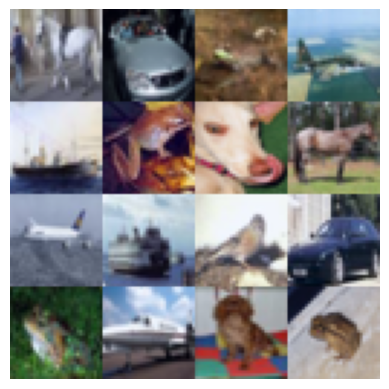

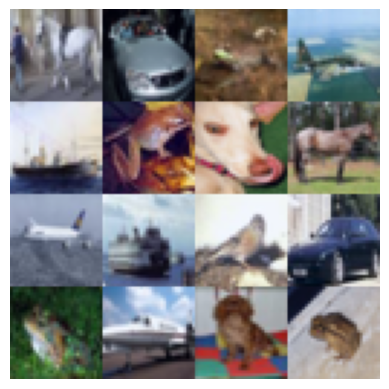

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type             | Params
--------------------------------------------
0 | _model | LightningWrapper | 2.8 M 
--------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.387    Total estimated model params size (MB)
/Users/ehsanulkabir/miniconda/envs/fl_gradattack/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/10000 [00:00<?, ?it/s] 

RuntimeError: derivative for aten::linear_backward is not implemented

In [11]:
att_pipeline = setup_attack()
run_gradient_attack(att_pipeline, attack_hparams, ensemble_gradient)

## Evaluate the attack

In [ ]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 KB 3.2 MB/s eta 0:00:00


In [ ]:
import argparse
import os

import lpips
import numpy as np
import torchmetrics
import torchvision

from gradattack.metrics.pixelwise import MeanPixelwiseError

PSNR = torchmetrics.functional.psnr
lpips_fn = lpips.LPIPS(net="vgg")

rootdir = '/content/drive/MyDrive/dl/gradA_data/batch_16_label_batchNorm'

rmse, psnr, lpips = [], [], []

decode_defense = False
if not decode_defense:
    for subdir, dirs, files in os.walk(rootdir):
        for file in (f for f in files
                     if f.startswith("reconstructed") and f.endswith(".npy")):
            recovered = np.load(os.path.join(subdir, "reconstructed.npy"))
            transform = np.load(os.path.join(subdir, "transformed.npy"))

            for r in recovered:
                tmp_rmse, tmp_psnr, tmp_lpips = [], [], []
                for t in transform:
                    recovered_tensor = torchvision.transforms.functional.to_tensor(
                        r)
                    transform_tensor = torchvision.transforms.functional.to_tensor(
                        t)
                    tmp_rmse.append(
                        MeanPixelwiseError(recovered_tensor, transform_tensor))
                    tmp_psnr.append(PSNR(recovered_tensor, transform_tensor))
                    tmp_lpips.append(
                        lpips_fn(recovered_tensor,
                                 transform_tensor).detach().numpy())
                rmse.append(min(tmp_rmse))
                psnr.append(max(tmp_psnr))
                lpips.append(min(tmp_lpips))
else:
    originals = np.load(os.path.join(rootdir, "originals.npy"))
    recovereds = np.load(os.path.join(rootdir, "grad_decode.npy"))

    for idx, original in enumerate(originals):
        original = torchvision.transforms.functional.to_tensor(original)
        recovered = torchvision.transforms.functional.to_tensor(
            recovereds[idx])

        rmse.append(MeanPixelwiseError(original, recovered))
        psnr.append(PSNR(recovered, original))
        lpips.append(lpips_fn(original, recovered).detach().numpy())

print(
    f"##### Avg. PSNR: {np.mean(psnr)} \t Avg. RMSE: {np.mean(rmse)} \t Avg. LPIPS: {np.mean(lpips)} #####"
)
print(
    f"##### Best PSNR: {np.max(psnr)} \t Best RMSE: {np.min(rmse)} \t Best LPIPS: {np.min(lpips)} #####"
)
print(
    f"##### PSNR std: {np.std(psnr)} \t RMSE std: {np.std(rmse)} \t LPIPS std: {np.std(lpips)} #####"
)


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/vgg.pth
##### Avg. PSNR: 12.92947769165039 	 Avg. RMSE: 0.28635692596435547 	 Avg. LPIPS: 0.6156487464904785 #####
##### Best PSNR: 15.108296394348145 	 Best RMSE: 0.23197557032108307 	 Best LPIPS: 0.48991328477859497 #####
##### PSNR std: 0.9659257531166077 	 RMSE std: 0.02236703410744667 	 LPIPS std: 0.047688763588666916 #####
